1. Import library

In [ ]:
import pandas as pd                  # for handling tabular data (dataframes)
import numpy as np                   # for basic numerical operations
import re                            # for text cleaning using regular expressions
import torch                         # for running the deep learning sentiment model
from transformers import AutoTokenizer, AutoModelForSequenceClassification  # for sentiment analysis
from wordcloud import WordCloud      # for generating wordcloud visualizations
import matplotlib.pyplot as plt      # for displaying plots and visualizations
import tweepy                        # for accessing the Twitter/X API

2. Disable Widgets & Progress Bars

HuggingFace transformers and other libraries sometimes create widgets or progress bars that break GitHub rendering.
These settings prevent widgets and make the notebook GitHub/VSCode compatible.

In [ ]:
import os
from transformers import logging

# Suppress HuggingFace warnings and widgets
logging.set_verbosity_error()

# Disable progress bars
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

# Disable telemetry
os.environ["DISABLE_TELEMETRY"] = "YES"

# Avoid parallel tokenizers issues
os.environ["TOKENIZERS_PARALLELISM"] = "false"

print("Widgets and progress bars disabled")

Widgets and progress bars disabled


3. Set all API credentials & initialize client

Use Consumer Key, Consumer Secret, Access Token, Access Token Secret, and Bearer Token. This allows full OAuth 1.1 access plus API v2 features. Read tweets with structured fields: date, author, text, likes, retweets, replies.

In [ ]:
consumer_key = "V4PX0G15PGca4fZqKeDJ318D8"
consumer_secret = "jBFnCseLoYHxnh55DVrBOpEbXhi6eNNNDlFlEYBPKYfJEg4q04"
access_token = "1990456788932825088-Ry6vfUuDY1aqKN3NP7AkLAmNMm0iom"
access_token_secret = "Zs5AiP5KZqlXATDLHFY3k0usufLVU61JpIZJp4zCOLY1X"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAIrs5QEAAAAAjiIfgBupPlAmqd8HivSa93CF9ow%3DGpYvRLVjHfLNXvuhYoC27EF1qQNYmJQEi58S54qFXYs0BXvf3l"

# OAuth1.1 (full access)
auth = tweepy.OAuth1UserHandler(
    consumer_key, consumer_secret, access_token, access_token_secret
)
api = tweepy.API(auth)
api.verify_credentials()
print("OAuth1.1 auth OK")

# API v2 Client (read-only structured tweets)
client = tweepy.Client(bearer_token=bearer_token)
print("Client v2 OK")

OAuth1.1 auth OK
Client v2 OK


4. Search recent tweets


Search recent tweets using the client. Filter by hashtags or keywords. Exclude retweets. Collect basic info: date and author.

In [ ]:
query = '(#Whoosh OR #KCIC OR #KeretaCepat OR "Whoosh" OR "KCIC" OR "kereta cepat") lang:id -is:retweet'

response = client.search_recent_tweets(
    query=query,
    max_results=100,  # max 100 per request
    tweet_fields=["created_at", "author_id", "public_metrics"]
)

tweets = response.data if response.data else []
print("Number of tweets found:", len(tweets))

Number of tweets found: 100


Notes:

* lang:id ensures tweets in Indonesian.

* public_metrics is optional but gives likes/retweets/replies if you want them.

* -is:retweet avoids duplicate content from retweets.

5. Create clean DataFrame.

Convert tweets to a table. Keep date, author, and text. Clean text by removing @usernames, URLs, and extra spaces.

In [ ]:
# Prepare rows for DataFrame
rows = []
for t in tweets:
    pm = t.public_metrics if getattr(t, "public_metrics", None) else {}

    # Clean text: remove mentions, URLs, extra whitespace
    clean_text = re.sub(r"@\w+|http\S+", "", t.text).strip()

    rows.append({
        "date": t.created_at,
        "author_id": t.author_id,
        "text": clean_text,
        "likes": pm.get("like_count", 0),
        "retweets": pm.get("retweet_count", 0),
        "replies": pm.get("reply_count", 0)
    })

# Create DataFrame
df = pd.DataFrame(rows)
df

,date,author_id,text,likes,retweets,replies
0,2025-11-17 16:37:38+00:00,43476922,Ilmu itu bisa berkembang kalo dikuasai oleh ma...,0,0,0
1,2025-11-17 16:25:19+00:00,1665235202770370560,Lebih tepatnya sengaja dipelihara. Supaya IKN ...,0,0,0
2,2025-11-17 16:21:49+00:00,1792097373092814849,kayanya KCIC gak secepet itu dah mungkin karen...,0,0,0
3,2025-11-17 16:20:10+00:00,46693036,Komisi Pemberantasan Korupsi (KPK) mengungkap ...,0,0,0
4,2025-11-17 16:06:10+00:00,887743587579944960,Dirut KCIC soal Utang Whoosh: Kita Serahkan ke...,8,6,0
...,...,...,...,...,...,...
95,2025-11-17 09:41:25+00:00,1114186502672502784,"Merch tergokil, tdnya mau ganci kcic juga. cum...",1,0,0
96,2025-11-17 09:36:19+00:00,963751550,Berita tolol macam gini ternyata muncul juga k...,0,0,0
97,2025-11-17 09:33:59+00:00,1885555382514507776,Menteri Keuangan Purbaya Yudhi Sadewa menjelas...,0,0,0
98,2025-11-17 09:28:47+00:00,1941143540,Nikah Siri dalam Kacamata Islam\n\n#UmrahKelua...,0,0,0


6. Load Sentiment Model

Load pre-trained sentiment model and tokenizer on CPU/GPU. Model will classify tweets as negative, neutral, or positive. Widgets and progress bars are already disabled.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()

label_map = {0: "negative", 1: "neutral", 2: "positive"}

print("Sentiment model loaded on", device)

Sentiment model loaded on cpu


7. Detect Sentiment & Add to DataFrame

Classify each tweet as positive, neutral, or negative and store confidence score. Results are appended to the DataFrame.

In [ ]:
sentiments = []
confidences = []

for text in df["text"]:
    s, c = detect_sentiment(text)
    sentiments.append(s)
    confidences.append(c)

df["sentiment"] = sentiments
df["confidence"] = confidences
df.head()

,date,author_id,text,likes,retweets,replies,sentiment,confidence
0,2025-11-17 16:37:38+00:00,43476922,Ilmu itu bisa berkembang kalo dikuasai oleh ma...,0,0,0,neutral,0.492462
1,2025-11-17 16:25:19+00:00,1665235202770370560,Lebih tepatnya sengaja dipelihara. Supaya IKN ...,0,0,0,negative,0.440134
2,2025-11-17 16:21:49+00:00,1792097373092814849,kayanya KCIC gak secepet itu dah mungkin karen...,0,0,0,neutral,0.633769
3,2025-11-17 16:20:10+00:00,46693036,Komisi Pemberantasan Korupsi (KPK) mengungkap ...,0,0,0,neutral,0.470405
4,2025-11-17 16:06:10+00:00,887743587579944960,Dirut KCIC soal Utang Whoosh: Kita Serahkan ke...,8,6,0,neutral,0.828925


8: Count & proportion of sentiments

Count how many tweets are positive, neutral, or negative, and show their percentage in the dataset. Gives a quick overview of sentiment distribution.

In [ ]:
# Count of each sentiment
print("Jumlah:", df["sentiment"].value_counts())

# Proportion (%) of each sentiment
print("\nProporsi (%):")
print((df["sentiment"].value_counts(normalize=True) * 100).round(2))

Jumlah: sentiment
neutral     51
negative    39
positive    10
Name: count, dtype: int64

Proporsi (%):
sentiment
neutral     51.0
negative    39.0
positive    10.0
Name: proportion, dtype: float64


9: WordCloud visualization

Generate a visual word cloud for tweets of a specific sentiment to see frequent words. Helps spot common topics or keywords.

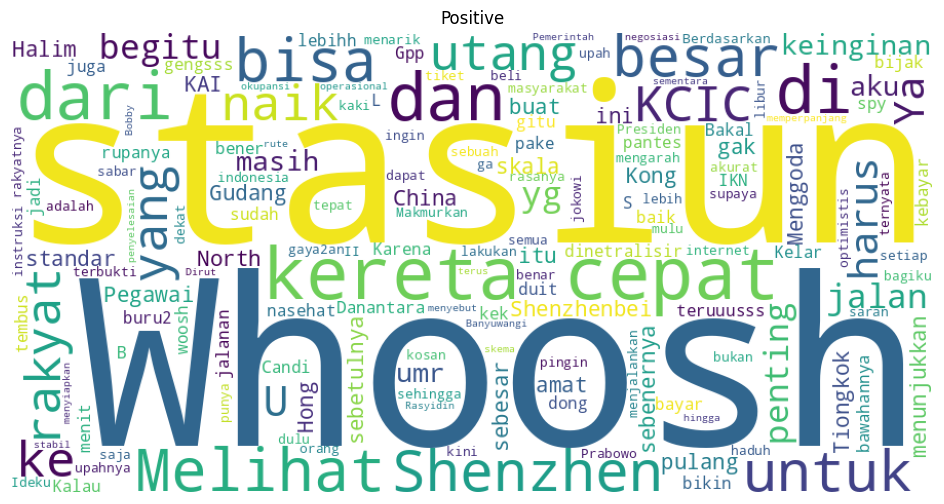

In [ ]:
def show_wordcloud(title, texts):
    if not texts:
        print(f"No tweets for {title}")
        return
    wc = WordCloud(width=900, height=450, background_color="white")
    img = wc.generate(" ".join(texts))
    plt.figure(figsize=(12,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Example: Positive tweets
show_wordcloud("Positive", df[df["sentiment"]=="positive"]["text"].tolist())

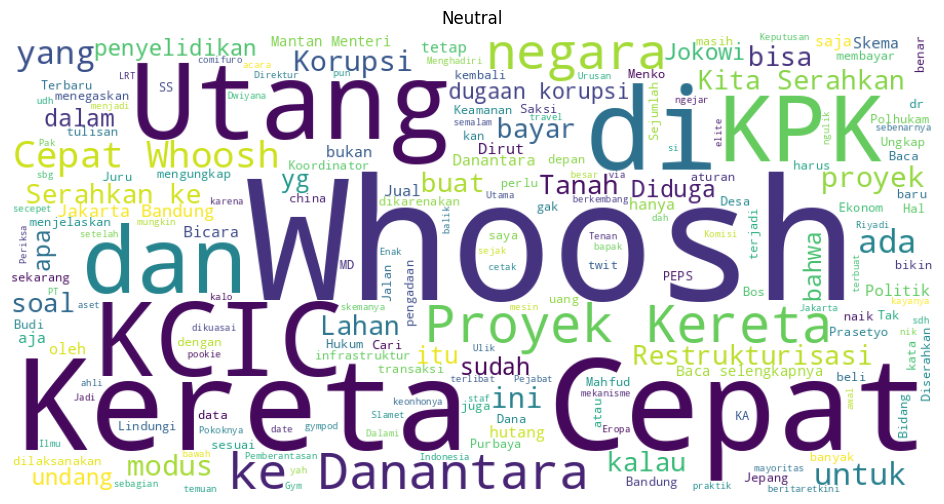

In [ ]:
# Neutral tweets
show_wordcloud("Neutral", df[df["sentiment"]=="neutral"]["text"].tolist())

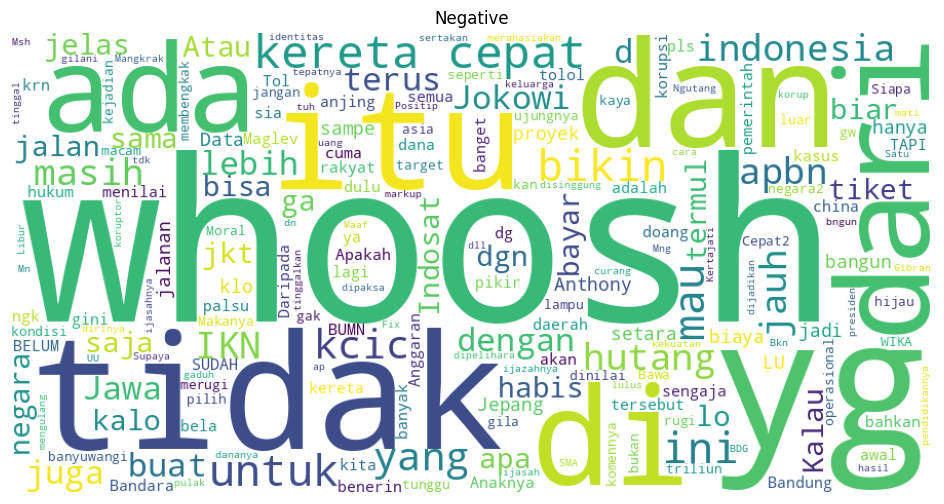

In [ ]:
# Negative tweets
show_wordcloud("Negative", df[df["sentiment"]=="negative"]["text"].tolist())

In [ ]:
df.to_csv("tweets_sentiment.txt", sep="\t", index=False, encoding="utf-8")
print("File saved: tweets_sentiment.txt")

File saved: tweets_sentiment.txt
